In [9]:
import pandas as pd
import os
import pandas
import konlpy
import gensim

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/DataFrom101/ddd/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/DataFrom101/ddd/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    # NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[3]

''

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [13]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
print(X_train[0])
get_decoded_sentence(X_train[0], index_to_word)

[32, 74, 939, 4, 4, 39, 229, 20, 33, 747]


'생각 쳐   지만 ~~ 좋 아 빨리'

In [15]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
import torch

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

X_train_padded = pad_sequences(X_train, maxlen)
X_test_padded = pad_sequences(X_test, maxlen)

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)

y_train_tensor = torch.tensor(y_train,dtype=torch.float)
y_test_tensor = torch.tensor(y_test,dtype=torch.float)

print(X_train_tensor.shape)

torch.Size([146182, 41])


In [17]:
# RNN 모델
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=30, batch_size=512, lr=0.001, device=None):
    
    # Device 설정
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 모델을 device로 이동
    model = model.to(device)
    
    # Optimizer와 Loss function 설정
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.BCELoss()
    
    # Dataset과 DataLoader 생성
    train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
    val_dataset = TensorDataset(X_test.to(device), y_test.to(device))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 결과 저장용 리스트
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # 학습 루프
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), labels)
                
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")
    
    # 결과 반환
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'model': model
    }


if __name__ == "__main__":
    results = train_model(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        epochs=30,
        batch_size=512,
        lr=0.001
    )
    
    # 결과 추출
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accs = results['train_accs']
    val_accs = results['val_accs']
    trained_model = results['model']

Using device: cuda:0
Epoch 1/30 - Train Loss: 0.6937, Train Accuracy: 0.5055 - Validation Loss: 0.6927, Validation Accuracy: 0.4973
Epoch 2/30 - Train Loss: 0.6921, Train Accuracy: 0.5062 - Validation Loss: 0.6911, Validation Accuracy: 0.5002
Epoch 3/30 - Train Loss: 0.6554, Train Accuracy: 0.6195 - Validation Loss: 0.6416, Validation Accuracy: 0.6538
Epoch 4/30 - Train Loss: 0.6452, Train Accuracy: 0.6305 - Validation Loss: 0.6428, Validation Accuracy: 0.6425
Epoch 5/30 - Train Loss: 0.6309, Train Accuracy: 0.6600 - Validation Loss: 0.6234, Validation Accuracy: 0.6772
Epoch 6/30 - Train Loss: 0.6216, Train Accuracy: 0.6751 - Validation Loss: 0.6352, Validation Accuracy: 0.6276
Epoch 7/30 - Train Loss: 0.6244, Train Accuracy: 0.6573 - Validation Loss: 0.6116, Validation Accuracy: 0.6932
Epoch 8/30 - Train Loss: 0.5975, Train Accuracy: 0.6987 - Validation Loss: 0.6088, Validation Accuracy: 0.6910
Epoch 9/30 - Train Loss: 0.5909, Train Accuracy: 0.7061 - Validation Loss: 0.5936, Validati

In [ ]:
train_losses = results['train_losses']
val_losses = results['val_losses']
train_accs = results['train_accs']
val_accs = results['val_accs']
trained_model = results['model']

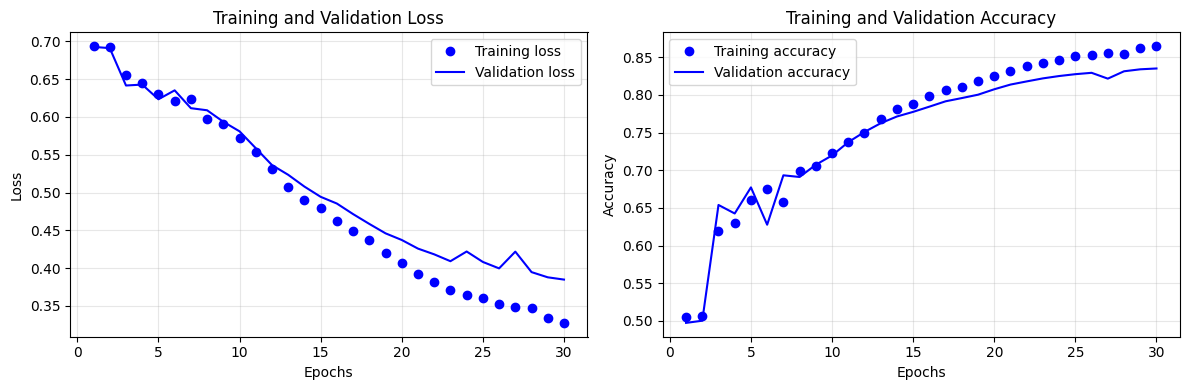

In [20]:
import matplotlib.pyplot as plt


def plot_training_history(train_losses, val_losses, train_accs, val_accs, 
                         figsize=(15, 5), save_path=None):
    """
    학습 결과(loss와 accuracy)를 시각화하는 함수
    
    Args:
        train_losses: 학습 손실 리스트
        val_losses: 검증 손실 리스트
        train_accs: 학습 정확도 리스트
        val_accs: 검증 정확도 리스트
        figsize: 그림 크기 (default: (15, 5))
        save_path: 그림을 저장할 경로 (default: None, 저장하지 않음)
    """
    
    epochs_range = range(1, len(train_losses) + 1)
    
    # Figure와 subplot 생성 (1행 2열)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 첫 번째 subplot - Loss
    ax1.plot(epochs_range, train_losses, 'bo', label='Training loss')
    ax1.plot(epochs_range, val_losses, 'b', label='Validation loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 두 번째 subplot - Accuracy
    ax2.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
    ax2.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 그림 저장 (옵션)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()


# 사용 예시 1: 기본 사용
# plot_training_history(train_losses, val_losses, train_accs, val_accs)

# # 사용 예시 2: 그림 크기 변경
plot_training_history(train_losses, val_losses, train_accs, val_accs, 
                     figsize=(12, 4))

# # 사용 예시 3: 그림 저장
# plot_training_history(train_losses, val_losses, train_accs, val_accs, 
#                      save_path='training_history.png')

# # 사용 예시 4: train_model 함수 결과와 함께 사용
# results = train_model(model, X_train_tensor, y_train_tensor, 
#                       X_test_tensor, y_test_tensor, epochs=30)

# plot_training_history(
#     results['train_losses'], 
#     results['val_losses'], 
#     results['train_accs'], 
#     results['val_accs']
# )

In [21]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [22]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join(os.getenv('HOME') + '/DataFrom101/ddd/embedding/word2vec.txt')

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [23]:
import os
my_word2vec_file_path = os.path.join(os.getenv('HOME') + '/DataFrom101/ddd/embedding/word2vec.txt')

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(my_word2vec_file_path, binary=False,encoding='utf-8')
vector = word_vectors['배우']
word_vectors.similar_by_word("배우")

[('채널', 0.75062495470047),
 ('말씀', 0.7384418845176697),
 ('겉도', 0.7336034178733826),
 ('엔딩', 0.7335307002067566),
 ('도무지', 0.7244979739189148),
 ('사골', 0.7204970121383667),
 ('테일러', 0.7194766402244568),
 ('한때', 0.7085229158401489),
 ('즐거웠', 0.7025963664054871),
 ('워라', 0.6973100900650024)]

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec

word2vec_file_path = "/home/summer24/DataFrom101/ddd/data/word2vec_ko.model"
model = Word2Vec.load(word2vec_file_path)
word_vector_model = model.wv
similar_words = word_vector_model.most_similar("배우")
similar_words

[('가수', 0.7729029655456543),
 ('코미디언', 0.7728644609451294),
 ('만화가', 0.749615490436554),
 ('영화배우', 0.7441834211349487),
 ('여배우', 0.7411354184150696),
 ('연출가', 0.7396705746650696),
 ('극작가', 0.7209770679473877),
 ('삽화가', 0.7152643799781799),
 ('안무가', 0.7149248123168945),
 ('무용가', 0.7118033766746521)]

In [26]:
model.vector_size

100

In [27]:
# 모델의 임베딩 layer를 Word2Vec으로 교체해서 다시 학습

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vector_model:
        embedding_matrix[i] = word_vector_model[index_to_word[i]]

embedding_matrix.shape

(10000, 100)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen,dropout_rate=0.3):
        super(SentimentModel2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.dropout_embedding = nn.Dropout(dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embedding(x)

        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)

        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)

        x = self.global_max_pool(x).squeeze(2)

        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model2 = SentimentModel2(vocab_size, word_vector_dim, embedding_matrix, maxlen,dropout_rate=0.3)
print(model2)

SentimentModel2(
  (embedding): Embedding(10000, 100)
  (dropout_embedding): Dropout(p=0.3, inplace=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv1): Conv1d(100, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
if __name__ == "__main__":
    # 모델 학습
    results = train_model(
        model=model2,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        epochs=30,
        batch_size=512,
        lr=0.001
    )
    
    # 결과 추출
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accs = results['train_accs']
    val_accs = results['val_accs']
    trained_model = results['model']

Using device: cuda:0
Epoch 1/30 - Train Loss: 0.6264, Train Accuracy: 0.6428 - Validation Loss: 0.5370, Validation Accuracy: 0.7519
Epoch 2/30 - Train Loss: 0.5143, Train Accuracy: 0.7483 - Validation Loss: 0.4684, Validation Accuracy: 0.7916
Epoch 3/30 - Train Loss: 0.4643, Train Accuracy: 0.7827 - Validation Loss: 0.4282, Validation Accuracy: 0.8160
Epoch 4/30 - Train Loss: 0.4332, Train Accuracy: 0.8027 - Validation Loss: 0.4223, Validation Accuracy: 0.8203
Epoch 5/30 - Train Loss: 0.4134, Train Accuracy: 0.8130 - Validation Loss: 0.4249, Validation Accuracy: 0.8055
Epoch 6/30 - Train Loss: 0.3978, Train Accuracy: 0.8223 - Validation Loss: 0.3983, Validation Accuracy: 0.8337
Epoch 7/30 - Train Loss: 0.3853, Train Accuracy: 0.8298 - Validation Loss: 0.3983, Validation Accuracy: 0.8279
Epoch 8/30 - Train Loss: 0.3770, Train Accuracy: 0.8344 - Validation Loss: 0.3982, Validation Accuracy: 0.8235
Epoch 9/30 - Train Loss: 0.3695, Train Accuracy: 0.8378 - Validation Loss: 0.3868, Validati

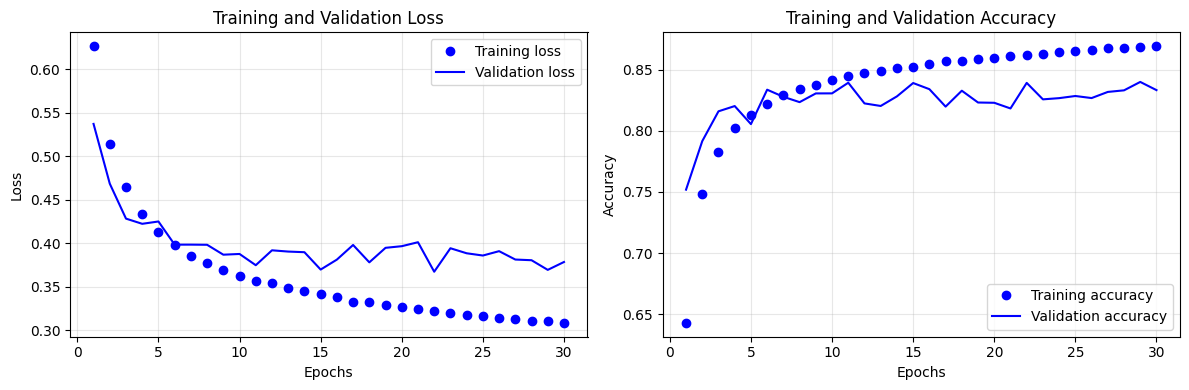

In [31]:
plot_training_history(train_losses, val_losses, train_accs, val_accs, 
                     figsize=(12, 4))

In [37]:
class SentimentCNNBiLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        word_vector_dim,
        embedding_matrix,
        maxlen,
        dropout_rate=0.3,
        cnn_channels=128,
        lstm_hidden=64
    ):
        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32)
        )
        self.embedding.weight.requires_grad = True
        self.dropout_emb = nn.Dropout(dropout_rate)

        # CNN (local n-gram feature)
        self.conv = nn.Conv1d(
            in_channels=word_vector_dim,
            out_channels=cnn_channels,
            kernel_size=5,
            padding=2
        )

        # BiLSTM (context modeling)
        self.lstm = nn.LSTM(
            input_size=cnn_channels,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # FC
        self.fc1 = nn.Linear(lstm_hidden * 2, 64)
        self.fc2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (B, T)
        x = self.embedding(x)              # (B, T, D)
        x = self.dropout_emb(x)

        # CNN expects (B, C, T)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv(x))           # (B, C', T)
        x = self.dropout(x)

        # LSTM expects (B, T, C)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)                # (B, T, 2H)

        # Global Max Pool over time
        x = torch.max(x, dim=1)[0]         # (B, 2H)

        # FC
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))

        return x



model3 = SentimentCNNBiLSTM(vocab_size, word_vector_dim, embedding_matrix, maxlen, dropout_rate=0.3, cnn_channels=128,lstm_hidden=64)
print(model3)

SentimentCNNBiLSTM(
  (embedding): Embedding(10000, 100)
  (dropout_emb): Dropout(p=0.3, inplace=False)
  (conv): Conv1d(100, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
if __name__ == "__main__":
    # 모델 학습
    results = train_model(
        model=model3,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        epochs=30,
        batch_size=512,
        lr=0.001
    )
    
    # 결과 추출
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accs = results['train_accs']
    val_accs = results['val_accs']
    trained_model = results['model']

Using device: cuda:0
Epoch 1/30 - Train Loss: 0.5668, Train Accuracy: 0.6971 - Validation Loss: 0.4781, Validation Accuracy: 0.7677
Epoch 2/30 - Train Loss: 0.4675, Train Accuracy: 0.7760 - Validation Loss: 0.4106, Validation Accuracy: 0.8127
Epoch 3/30 - Train Loss: 0.4243, Train Accuracy: 0.8024 - Validation Loss: 0.3811, Validation Accuracy: 0.8285
Epoch 4/30 - Train Loss: 0.3925, Train Accuracy: 0.8219 - Validation Loss: 0.3718, Validation Accuracy: 0.8320
Epoch 5/30 - Train Loss: 0.3726, Train Accuracy: 0.8337 - Validation Loss: 0.3480, Validation Accuracy: 0.8456
Epoch 6/30 - Train Loss: 0.3579, Train Accuracy: 0.8430 - Validation Loss: 0.3421, Validation Accuracy: 0.8503
Epoch 7/30 - Train Loss: 0.3460, Train Accuracy: 0.8480 - Validation Loss: 0.3401, Validation Accuracy: 0.8525
Epoch 8/30 - Train Loss: 0.3352, Train Accuracy: 0.8534 - Validation Loss: 0.3449, Validation Accuracy: 0.8519
Epoch 9/30 - Train Loss: 0.3300, Train Accuracy: 0.8570 - Validation Loss: 0.3349, Validati

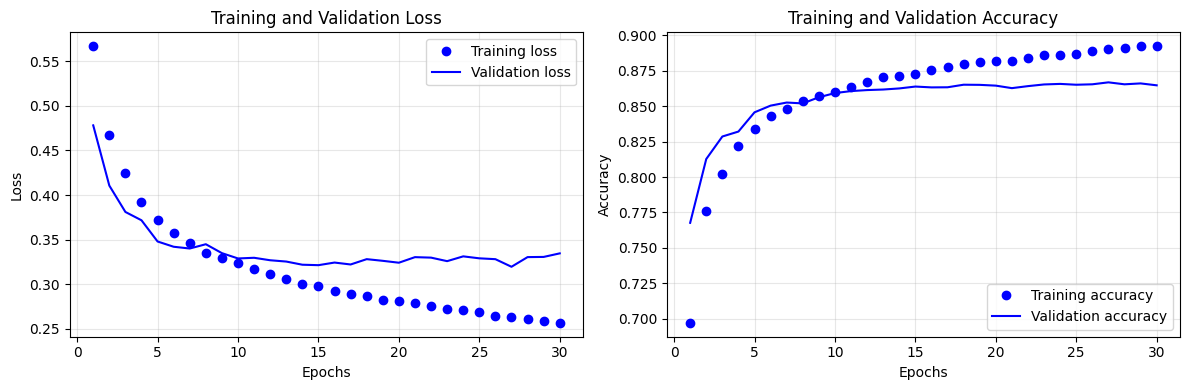

In [39]:
plot_training_history(train_losses, val_losses, train_accs, val_accs, 
                     figsize=(12, 4))